In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import glob
import numpy as np
import astropy.io.fits as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = True
from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis,create_gti_mask
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood
from scipy.optimize import curve_fit
#from sklearn.mixture import GaussianMixturet
from sklearn import mixture
from sklearn.cluster import KMeans

In [2]:
files_A=glob.glob("*/*_0mpu7_cl.evt")

In [3]:
all_evs=[]
for i in files_A:
    all_ev=EventList.read(i, 'hea')
    all_evs.append(all_ev)
lcs=[]
for i in all_evs:
    lc = i.to_lc(10)
    lcs.append(lc)

/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/io.py:239: UserWarning: Column energy not found
  warnings.warn("Column " + a + " not found")
/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/io.py:239: UserWarning: Column energy not found
  warnings.warn("Column " + a + " not found")


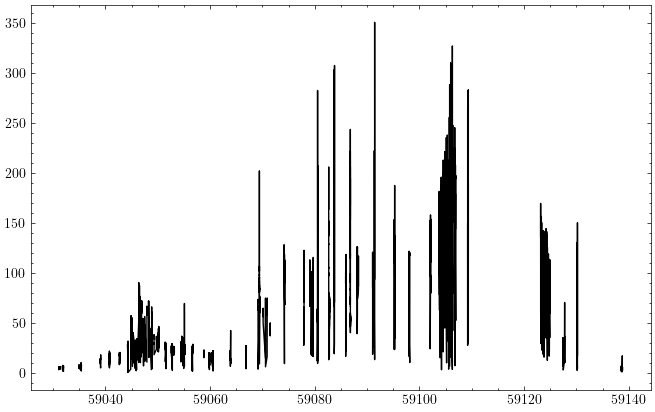

In [4]:
fig, axs = plt.subplots(1,1,figsize=(8, 5))
i=0
OBSIDS=[]
while i < len(lcs):
    MJDOBS=all_evs[i].mjdref+fits.open(files_A[i])[0].header['tstart']/86400.
    OBSID=fits.open(files_A[i])[1].header['OBS_ID']
    EXPO=fits.open(files_A[i])[1].header['exposure']
    mk = lcs[i].countrate > 0
    #59279 .. 59556
    #58238–58634
    if float(MJDOBS) > 59030 and float(MJDOBS) < 59140 and float(EXPO) > 500:
        axs.plot(lcs[i].time[mk]/86400.+all_evs[i].mjdref, lcs[i].countrate[mk],'-k')
        mean_rate=np.mean(lcs[i].countrate[mk])
        #OBSIDS.append(OBSID)
        OBSIDS.append([mean_rate,float(MJDOBS),OBSID, EXPO])
    #axs.legend()
    i+=1

In [5]:
#plt.subplots_adjust(hspace=0)
OBSIDS = sorted(OBSIDS, key=lambda x: x[1])
files_new=[]
for i in OBSIDS:
    #file="/Volumes/5T_disk1/Data/GRS1915p105/NICER/results/%s/ni%s_0mpu7_cl.evt"%(i,i)
    #files_new.append(file)
    print(i[0],i[1],i[2],int(i[3]))

4.807246376811594 59031.08314546654 3103010239 692
5.160165975103734 59031.780657611656 3607011802 2392
6.12542372881356 59034.94383127782 3103010240 595
6.597727272727272 59035.00825375001 3103010241 1752
12.993377483443709 59039.01839201814 3607011901 3012
16.182539682539684 59040.75589270668 3103010242 619
16.98815789473684 59042.64570706925 3607011902 1510
38.74019607843137 59044.246399412026 3103010243 980
32.252722063037254 59045.021865457595 3103010244 6816
48.26387337057728 59046.00287884908 3103010245 5294
47.88666666666667 59046.56214178714 3607012001 843
48.44585537918872 59047.01365795133 3103010246 5604
51.1108504398827 59048.24277866099 3103010247 3352
33.46917293233083 59049.275568829806 3103010248 1319
37.64652406417112 59050.05381872047 3607012002 1852
24.38347826086956 59051.4260276319 3103010250 1105
22.589054726368158 59052.57208097884 3103010251 1968
22.036320754716986 59053.03066011634 3607012101 2114
27.801308900523555 59054.24457266333 3103010252 3771
24.8098930

In [6]:
all_evs_new=[]
for i in OBSIDS:
    file="%s/ni%s_0mpu7_cl.evt"%(i[2],i[2])
    ev=EventList.read(file, 'hea')
    all_evs_new.append(ev)

/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/io.py:239: UserWarning: Column energy not found
  warnings.warn("Column " + a + " not found")


In [7]:
#join all evts files
i=1
whole_ev=all_evs_new[0]
while i < len(all_evs_new):
    whole_ev=whole_ev.join(all_evs_new[i])
    i+=1

/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/utils.py:267: UserWarning: SIMON says: GTIs in these two event lists do not overlap at all.Merging instead of returning an overlap.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/utils.py:267: UserWarning: SIMON says: GTIs in these two event lists do not overlap at all.Merging instead of returning an overlap.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/Users/kldsky/miniconda3/lib/python3.11/site-packages/stingray/utils.py:267: UserWarning: SIMON says: GTIs in these two event lists do not overlap at all.Merging instead of returning an overlap.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [8]:
all = (whole_ev.energy >=1.0) & (whole_ev.energy <=10.0)
whole_ev = whole_ev.apply_mask(all)

In [9]:
min(whole_ev.energy),max(whole_ev.energy)

(1.0, 10.0)

In [10]:
lc1 = whole_ev.to_lc(10)
gti0 = create_gti_from_condition(lc1.time, lc1.countrate > 0, safe_interval=1)
#gti0 = lc1.gti
new_gti1 = create_gti_mask(lc1.time,gti0,min_length=400, return_new_gtis=True)
new_gti1 = new_gti1[1]
lc1.gti=new_gti1
lc1.apply_gtis()
LC1 = lc1.split_by_gti(gti=new_gti1)

In [11]:
print(len(gti0),len(new_gti1))

245 158


In [12]:
#make lc for pds:
dt=0.05
lc = whole_ev.to_lc(dt)
# gti0 = create_gti_from_condition(lc.time, lc.counts > 0)
# #gti0 = lc1.gti
# new_gti1 = create_gti_mask(lc.time,gti0,min_length=100, return_new_gtis=True)
# new_gti1 = new_gti1[1]
lc.gti=new_gti1
lc.apply_gtis()
LC = lc.split_by_gti(gti=new_gti1)

In [13]:
#make lc for light curve with different energy bands:
soft = (whole_ev.energy >=1.0) & (whole_ev.energy <=4.0)
hard = (whole_ev.energy >=4.0) & (whole_ev.energy <=10.0)
whole_ev_soft = whole_ev.apply_mask(soft)
whole_ev_hard = whole_ev.apply_mask(hard)

lc_soft = whole_ev_soft.to_lc(100)
lc_soft.gti=new_gti1
lc_soft.apply_gtis()
LC_soft = lc_soft.split_by_gti(gti=new_gti1)

lc_hard = whole_ev_hard.to_lc(100)
lc_hard.gti=new_gti1
lc_hard.apply_gtis()
LC_hard = lc_hard.split_by_gti(gti=new_gti1)

In [14]:
#find time interval
intervals1=[0]
n=0
while n < len(LC1)-1:
    interval1=LC1[n+1].time[0]-LC1[n].time[-1]
    intervals1.append(interval1)    
    n+=1
intervals_new1=[0]
i=1
while i < len(intervals1):
    inter=sum(intervals1[:i+1])
    intervals_new1.append(inter)
    i+=1
intervals1=intervals_new1

In [15]:
%%capture
import stingray
DPS=[]
j=0
while j < len(LC):
    print(j)
    dps = stingray.DynamicalPowerspectrum(LC[j], segment_size=200, norm='leahy')
    print(len(dps.time),dps.dyn_ps.shape)
    #dps.rebin_frequency(df_new=0.1, method="average")
    DPS.append(dps)
    j+=1

In [16]:
intervals2=[0]
n=0
while n < len(DPS)-1:
    interval2=DPS[n+1].time[0]-DPS[n].time[-1]
    intervals2.append(interval2)    
    n+=1
intervals_new2=[0]
i=1
while i < len(intervals2):
    inter=sum(intervals2[:i+1])
    intervals_new2.append(inter)
    i+=1
intervals2=intervals_new2

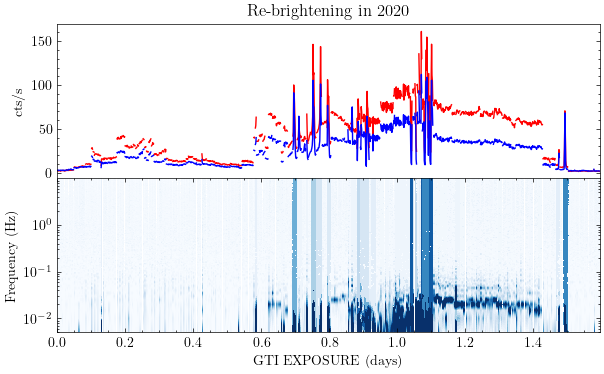

In [17]:
fig, axs = plt.subplots(2,1,figsize=(7, 4))
#for i,j in zip(intervals1,LC1):
#    time1=(j.time-i)/86400.+56658.00077759259
#    time1_ref=time1-(LC1[0].time[0]/86400.+56658.00077759259)
#    axs[0].plot(time1_ref, j.countrate,'-k')
    #axs[0].axvline(x=time1_ref[0],ls='--',color='red',alpha=0.3)
    #axs[0].axvline(x=time1_ref[-1],ls='--',color='red',alpha=0.3)
for i,j in zip(intervals1,LC_soft):
    time1=(j.time-i)/86400.+56658.00077759259
    time1_ref=time1-(LC1[0].time[0]/86400.+56658.00077759259)
    axs[0].plot(time1_ref, j.countrate,'-r',label='1.0-3.0 keV')
    #axs[0].axvline(x=time1_ref[0],ls='--',color='red',alpha=0.3)
    #axs[0].axvline(x=time1_ref[-1],ls='--',color='red',alpha=0.3)
for i,j in zip(intervals1,LC_hard):
    time1=(j.time-i)/86400.+56658.00077759259
    time1_ref=time1-(LC1[0].time[0]/86400.+56658.00077759259)
    axs[0].plot(time1_ref, j.countrate,'-b',label='5.0-10.0 keV')
    #axs[0].axvline(x=time1_ref[0],ls='--',color='red',alpha=0.3)
    #axs[0].axvline(x=time1_ref[-1],ls='--',color='red',alpha=0.3)
for i,j in zip(intervals1,DPS):
    time2=(j.time-i)/86400.+56658.00077759259
    #time2=(j.time)/86400.+56658.00077759259
    time2_ref=time2-(LC1[0].time[0]/86400.+56658.00077759259)
    xx, yy = np.meshgrid(time2_ref,j.freq)
    #print(j.dyn_ps)
    #extent = min(j.time), max(j.time), max(j.freq), min(j.freq)
    #axs[1].imshow(j.dyn_ps, vmin=0, vmax=0.1,interpolation="none", extent=extent)
    #axs[1].imshow(j.dyn_ps)
    axs[1].contourf(xx,yy,j.dyn_ps-2,50,cmap='Blues',vmin=0.001, vmax=150)
    #axs[1].contourf(xx,yy,j.dyn_ps-2,50,cmap='Blues')
    #axs[1].axvline(x=time2_ref[0],ls='--',color='red',alpha=0.3)
    #axs[1].axvline(x=time2_ref[-1],ls='--',color='red',alpha=0.3)    
axs[0].set_xticks([])
#axs[1].set_xticks([])
axs[1].set_yscale('log')    
axs[0].set_xlim(0,max(time1_ref))
axs[1].set_xlim(0,max(time2_ref))
axs[0].set_ylabel('cts/s')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_xlabel('GTI EXPOSURE (days)')
axs[0].set_title('Re-brightening in 2020')
plt.subplots_adjust(hspace=0,wspace=0)
#plt.savefig("pds_all_2021.pdf")
plt.show()

In [18]:
fig.savefig("pds_all_2020.png")